*Problem*: We analysed a set of 922 patients with invasive breast cancer and pre-operative MRI. The MRIs were analysed by a
computer algorithm to extract 529 features of the tumour and the surrounding tissue. Machine-learning-based models based on the
imaging features were trained using a portion of the data (461 patients) to predict tumour surrogate molecular subtype ER

In [239]:
# Reload a package
from importlib import reload  
import utils.MRIDataset
foo = reload(utils.MRIDataset)

In [219]:
# Packages
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import glob
import pydicom as dicom
import shap

# Local packages 
from utils.dataset import download_files, make_table
from utils.metrics import evaluate,evaluate_test
from utils.imageDataset import ImageDataset

# STATS
from sklearn.feature_selection import SelectKBest, f_classif,chi2
from scipy import stats

# model
from sklearn.model_selection import RandomizedSearchCV,  GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier


# Evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,f1_score,roc_curve, auc,log_loss,roc_auc_score,average_precision_score
from sklearn.metrics import balanced_accuracy_score,brier_score_loss,classification_report

# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler


#export 


import pydicom,kornia,skimage
from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
from PIL import Image

try:
    import cv2
    cv2.setNumThreads(0)
except: pass

# Inore warnings
import warnings
warnings.filterwarnings("ignore")


# Computer vision
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.transforms import (
    LoadImage, LoadImaged, EnsureChannelFirstd,
    Resized, EnsureTyped, Compose
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism
from monai.data import ITKReader, PILReader

print_config()
# Pandas options
plt.rcParams['axes.facecolor'] = 'black'
params = {"ytick.color" : "b",
          "xtick.color" : "b",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
         "axes.titlecolor": "w",
          'text.color':"b"
         }
lunit_colors=['#01c9ea',"w"]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

MONAI version: 0.8.0
Numpy version: 1.21.4
Pytorch version: 1.10.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.1
scikit-image version: 0.16.2
Pillow version: 7.2.0
Tensorboard version: 2.7.0
gdown version: 4.2.0
TorchVision version: 0.11.1+cpu
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.7.2
pandas version: 1.1.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 3.0.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [7]:
# Variables 
race_dict={0 : "N/A",
                1 : "white",
                2 : "black",
                3 : "asian",
                4 : "native",
                5 : "hispanic",
                6 : "multi",
                7 : "hawa",    
                8 : "amer indian"}
target_dict= {0 : "ER negative",1 : "ER positive"}

### datasets

In [8]:
# Download excel sheets
download_files()
# Define tables
clinical_df, images_df, test_df,dict_features = make_table() 
# Define target
target='ER'

Reading dataframes...
Droping columns with only nan values...
Extract clinical features...
Set index...
Done...


In [9]:
print("Features:")
dict_features 

Features:


{'Patient Information': ['Patient ID'],
 'MRI Technical Information': ['Days to MRI (From the Date of Diagnosis)',
  'Manufacturer',
  'Manufacturer Model Name',
  'Scan Options',
  'Field Strength (Tesla)',
  'Patient Position During MRI',
  'Image Position of Patient',
  'Contrast Agent',
  'Contrast Bolus Volume (mL)',
  'TR (Repetition Time)',
  'TE (Echo Time)',
  'Acquisition Matrix',
  'Slice Thickness ',
  'Rows',
  'Columns',
  'Reconstruction Diameter ',
  'Flip Angle \n',
  'FOV Computed (Field of View) in cm '],
 'Demographics': ['Date of Birth (Days)',
  'Menopause (at diagnosis)',
  'Race and Ethnicity',
  'Metastatic at Presentation (Outside of Lymph Nodes)'],
 'Tumor Characteristics': ['ER',
  'PR',
  'HER2',
  'Mol Subtype',
  'Oncotype score',
  'Staging(Tumor Size)# [T]',
  'Staging(Nodes)#(Nx replaced by -1)[N]',
  'Staging(Metastasis)#(Mx -replaced by -1)[M]',
  'Tumor Grade',
  'Tumor Grade.1',
  'Tumor Grade.2',
  'Nottingham grade',
  'Histologic type',
  'Tumor

### Demographics

In [132]:
# Keep only demographics data with target
demo_df=clinical_df[[col for col in clinical_df.columns if col in dict_features['Demographics']  ]+[target]]
# Change types
demo_df = demo_df.astype("float")
# Categorize Ethnicity
demo_df['Race and Ethnicity'] = demo_df['Race and Ethnicity'].map(race_dict)
# AGE 
demo_df['Date of Birth (Days)']  = np.abs(demo_df['Date of Birth (Days)']/360)
demo_df.head()

Date of Birth (Days)  Menopause (at diagnosis)  \
Patient ID                                                       
Breast_MRI_001             42.247222                       0.0   
Breast_MRI_002             39.058333                       0.0   
Breast_MRI_003             63.013889                       1.0   
Breast_MRI_004             59.663889                       1.0   
Breast_MRI_005             38.700000                       0.0   

               Race and Ethnicity  \
Patient ID                          
Breast_MRI_001              black   
Breast_MRI_002              black   
Breast_MRI_003              white   
Breast_MRI_004              white   
Breast_MRI_005           hispanic   

                Metastatic at Presentation (Outside of Lymph Nodes)   ER  
Patient ID                                                                
Breast_MRI_001                                                0.0    0.0  
Breast_MRI_002                                                0.0    0.0  
Breast_MRI_003                                                0.0    1.0  
Breast_MRI_004                                                0.0    1.0  
Breast_MRI_005                                                0.0    1.0

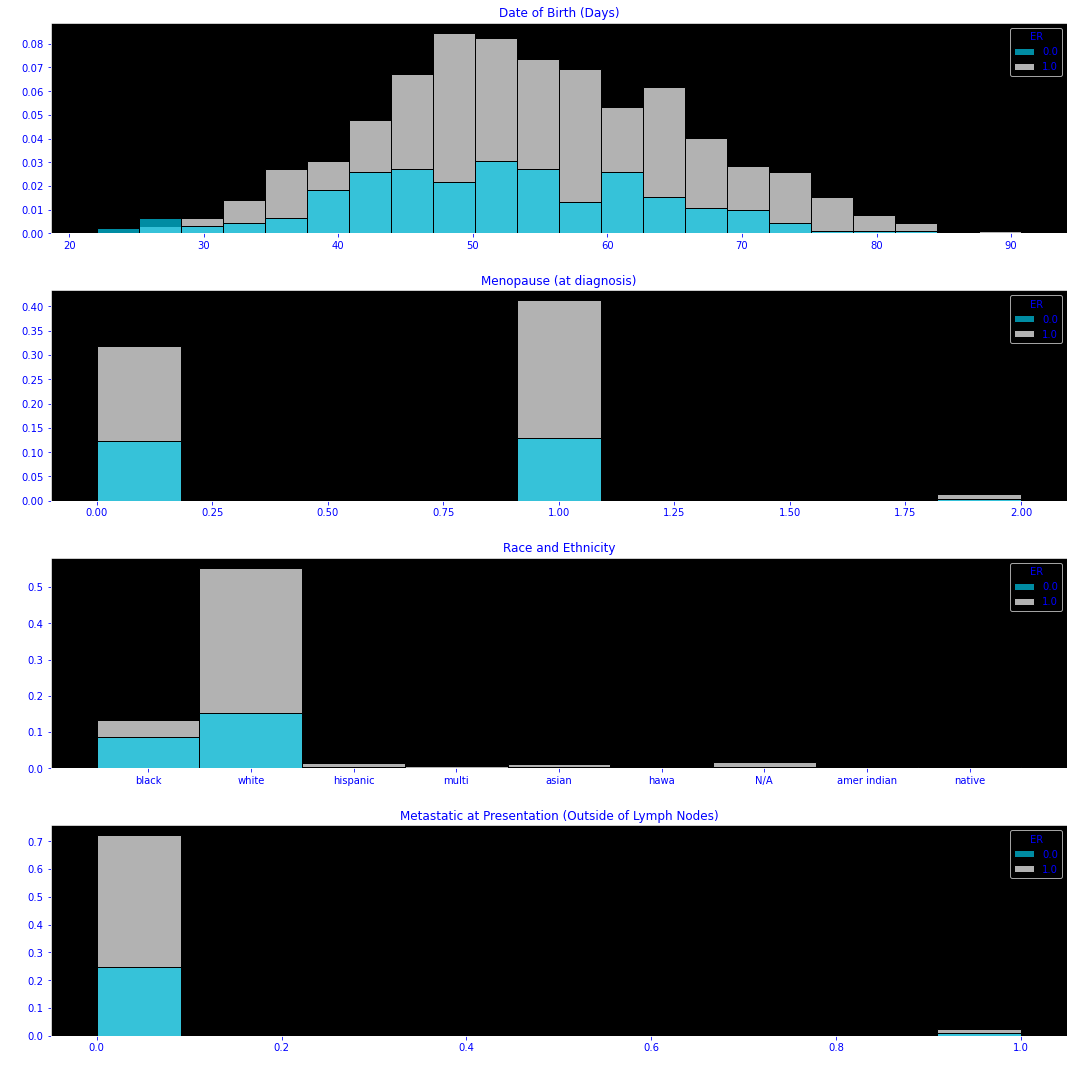

In [133]:
fig, axs = plt.subplots(4, 1,figsize=(15,15))


for i,col in enumerate(demo_df.columns[:-1]):

    elem=(demo_df.groupby(col)[target].sum()/demo_df.groupby(col)[target].count()).reset_index()
    sns.histplot(data = demo_df,x = col ,alpha = .7, palette=lunit_colors,hue = target,ax=axs[i],stat="probability").set_title(col,color="b")
    
fig.tight_layout(pad=1.0)
plt.rcParams.update(params)
plt.show()
fig.savefig('images/clinical_featurs.png')

White women are more likely to be diagnosed with subtype tumor ER, whereas 80% of black women are safe from this subtype

Distribution of age is nearly normal and we can’t deduce any impact so far on the classification

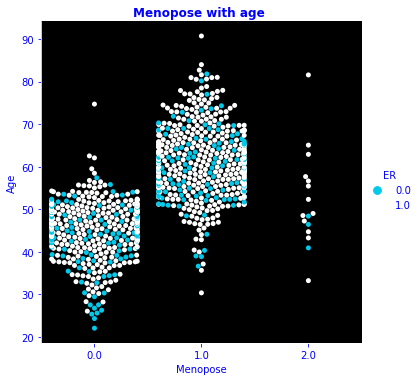

In [135]:
# multivariate 
params = {"ytick.color" : "b",
          "xtick.color" : "b",
          "xlabel.color" : "black",
           "ylabel.color" : "black",
          "axes.labelcolor" : "b",
          "axes.edgecolor" : "b",
         "axes.titlecolor": "b",
          "axes.xlabel.title":"b",
          'text.color':"b"
         }
lunit_colors=['#01c9ea',"w"]

ax=sns.catplot(x="Menopause (at diagnosis)", y="Date of Birth (Days)", hue="ER", kind="swarm", palette=lunit_colors, data=demo_df)
ax.set(xlabel='common xlabel', ylabel='common ylabel')
plt.title("Menopose with age ",fontsize=12, pad=5, fontdict={"weight": "bold"},color="b")
plt.xlabel("Menopose",color="b")
plt.ylabel("Age",color="b")
plt.show()
ax.savefig('images/menopose_with_age.png')

In [136]:
# DEFINE NEW FEATURE:(only on train )
demo_df.groupby(['Menopause (at diagnosis)',target])['Date of Birth (Days)'].median()
# patients only in train
patients_train=list(set(demo_df.index)-set(test_df.index))
# Define the categories
print(demo_df.loc[patients_train].groupby(['Menopause (at diagnosis)',target])['Date of Birth (Days)'].median()[0])
limit_0=demo_df.loc[patients_train].groupby(['Menopause (at diagnosis)',target])['Date of Birth (Days)'].median()[0,1]
limit_1=demo_df.loc[patients_train].groupby(['Menopause (at diagnosis)',target])['Date of Birth (Days)'].median()[1,1]
def meno_age(x,y):
    if x==0:
        if y<=limit_0:
            return "not likely" 
        else:
            return "likely"
    else:
        if y<=limit_1:
            return "not likely" 
        else:

            return "likely"
#define new column
demo_df['Monopose_age']=demo_df[['Menopause (at diagnosis)','Date of Birth (Days)']].apply(lambda x: meno_age(x['Menopause (at diagnosis)'],x['Date of Birth (Days)']),axis=1 )

demo_df.groupby('Monopose_age')[target].sum()

ER
0.0    43.708333
1.0    45.961111
Name: Date of Birth (Days), dtype: float64


Monopose_age
likely        347.0
not likely    339.0
Name: ER, dtype: float64

Text(0.5, 1.0, 'Metastatic at Presentation (Outside of Lymph Nodes)')

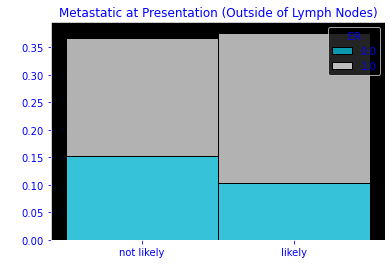

In [137]:
sns.histplot(data = demo_df,x = 'Monopose_age' ,alpha = .7, palette=lunit_colors,hue = target,stat="probability").set_title(col,color="b")


### MRI technical informatio
Doe the scan MRI info such as: Manufacturer,Manufacturer model name,Scan option..impat the detection of the subtype of tumor ER

In [149]:
# Keep only demographics data with target
mri_df=clinical_df[[col for col in clinical_df.columns if col in dict_features['MRI Technical Information']  ]+[target]]


# Split features 
mri_df['Image Position of Patient X'],\
mri_df['Image Position of Patient Y'],\
mri_df['Image Position of Patient Z'] =\
mri_df['Image Position of Patient'].str.split(" X ",expand=True)[0],\
mri_df['Image Position of Patient'].str.split(" X ",expand=True)[1],\
mri_df['Image Position of Patient'].str.split(" X ",expand=True)[2]

mri_df.drop(columns='Image Position of Patient',inplace=True)

# Correct negative days 
# Change types
mri_df = mri_df.astype("float")
mri_df.head()

Days to MRI (From the Date of Diagnosis)  Manufacturer  \
Patient ID                                                               
Breast_MRI_001                                       6.0           2.0   
Breast_MRI_002                                      12.0           0.0   
Breast_MRI_003                                      10.0           0.0   
Breast_MRI_004                                      18.0           0.0   
Breast_MRI_005                                      12.0           2.0   

                Manufacturer Model Name  Scan Options  Field Strength (Tesla)  \
Patient ID                                                                      
Breast_MRI_001                      0.0           5.0                     1.0   
Breast_MRI_002                      4.0           1.0                     3.0   
Breast_MRI_003                      3.0           2.0                     3.0   
Breast_MRI_004                      4.0           1.0                     1.0   
Breast_MRI_005                      0.0           5.0                     1.0   

                Patient Position During MRI  Contrast Agent  \
Patient ID                                                    
Breast_MRI_001                          0.0             1.0   
Breast_MRI_002                          0.0             1.0   
Breast_MRI_003                          0.0             1.0   
Breast_MRI_004                          0.0             1.0   
Breast_MRI_005                          1.0             1.0   

                Contrast Bolus Volume (mL)  TR (Repetition Time)  \
Patient ID                                                         
Breast_MRI_001                        15.0                 4.120   
Breast_MRI_002                         NaN                 6.918   
Breast_MRI_003                         NaN                 5.527   
Breast_MRI_004                         NaN                 4.856   
Breast_MRI_005                         5.0                 4.270   

                TE (Echo Time)  Acquisition Matrix  Slice Thickness   Rows  \
Patient ID                                                                   
Breast_MRI_001           1.360                 9.0               5.0   1.0   
Breast_MRI_002           2.704                 5.0              12.0   2.0   
Breast_MRI_003           2.416                 2.0              18.0   2.0   
Breast_MRI_004           2.260                 1.0              18.0   2.0   
Breast_MRI_005           1.340                 9.0              18.0   1.0   

                Columns  Reconstruction Diameter   Flip Angle \n  \
Patient ID                                                         
Breast_MRI_001      1.0                       NaN            3.0   
Breast_MRI_002      2.0                       4.0            2.0   
Breast_MRI_003      2.0                      10.0            2.0   
Breast_MRI_004      2.0                      11.0            2.0   
Breast_MRI_005      1.0                       NaN            2.0   

                FOV Computed (Field of View) in cm    ER  \
Patient ID                                                 
Breast_MRI_001                                 15.0  0.0   
Breast_MRI_002                                  5.0  0.0   
Breast_MRI_003                                 14.0  1.0   
Breast_MRI_004                                 15.0  1.0   
Breast_MRI_005                                 14.0  1.0   

                Image Position of Patient X  Image Position of Patient Y  \
Patient ID                                                                 
Breast_MRI_001                    -191.8003                    -176.1259   
Breast_MRI_002                     154.7240                     176.0480   
Breast_MRI_003                     174.6580                     228.3170   
Breast_MRI_004                     188.1480                     194.2820   
Breast_MRI_005                    -173.0630                    -150.7869   

                Image Position o

In [150]:
# Deal with columns with a lot of nan values:
print(mri_df.isna().sum())
mri_df.drop(columns=["Contrast Bolus Volume (mL)","Reconstruction Diameter "],inplace=True)
mri_df.head(2)

Days to MRI (From the Date of Diagnosis)      0
Manufacturer                                  0
Manufacturer Model Name                       0
Scan Options                                  0
Field Strength (Tesla)                        0
Patient Position During MRI                   0
Contrast Agent                                5
Contrast Bolus Volume (mL)                  653
TR (Repetition Time)                          0
TE (Echo Time)                                0
Acquisition Matrix                            0
Slice Thickness                               0
Rows                                          0
Columns                                       0
Reconstruction Diameter                     294
Flip Angle \n                                 0
FOV Computed (Field of View) in cm            0
ER                                            0
Image Position of Patient X                   0
Image Position of Patient Y                   0
Image Position of Patient Z             

Days to MRI (From the Date of Diagnosis)  Manufacturer  \
Patient ID                                                               
Breast_MRI_001                                       6.0           2.0   
Breast_MRI_002                                      12.0           0.0   

                Manufacturer Model Name  Scan Options  Field Strength (Tesla)  \
Patient ID                                                                      
Breast_MRI_001                      0.0           5.0                     1.0   
Breast_MRI_002                      4.0           1.0                     3.0   

                Patient Position During MRI  Contrast Agent  \
Patient ID                                                    
Breast_MRI_001                          0.0             1.0   
Breast_MRI_002                          0.0             1.0   

                TR (Repetition Time)  TE (Echo Time)  Acquisition Matrix  \
Patient ID                                                                 
Breast_MRI_001                 4.120           1.360                 9.0   
Breast_MRI_002                 6.918           2.704                 5.0   

                Slice Thickness   Rows  Columns  Flip Angle \n  \
Patient ID                                                       
Breast_MRI_001               5.0   1.0      1.0            3.0   
Breast_MRI_002              12.0   2.0      2.0            2.0   

                FOV Computed (Field of View) in cm    ER  \
Patient ID                                                 
Breast_MRI_001                                 15.0  0.0   
Breast_MRI_002                                  5.0  0.0   

                Image Position of Patient X  Image Position of Patient Y  \
Patient ID                                                                 
Breast_MRI_001                    -191.8003                    -176.1259   
Breast_MRI_002                     154.7240                     176.0480   

                Image Position of Patient Z  
Patient ID                                   
Breast_MRI_001                      86.6065  
Breast_MRI_002                      94.5771

Some columns have more than 10% of the records missing, so we remove them first after checking their correlation with the target 

In [151]:
# Define categorical columns: 
mri_cat_cols=["Manufacturer","Manufacturer Model Name","Scan Options","Patient Position During MRI"]
for col in mri_cat_cols:
    mri_df[col]= mri_df[col].astype('object')


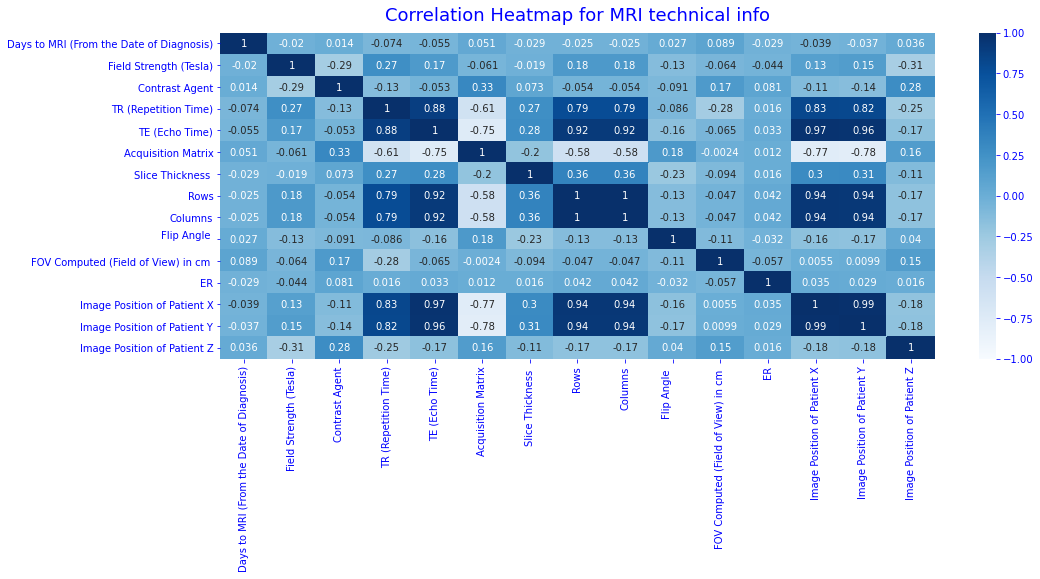

In [152]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(mri_df.corr(), vmin=-1, vmax=1, annot=True,cmap="Blues")
heatmap.set_title('Correlation Heatmap for MRI technical info', fontdict={'fontsize':18}, pad=12,color="b");
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('images/heatmap_mri_info.png', dpi=300, bbox_inches='tight')

In [153]:
# Drop very correlated features
cor_matrix = mri_df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
mri_df = mri_df.drop(mri_df[to_drop], axis=1)
mri_df .head()

Days to MRI (From the Date of Diagnosis) Manufacturer  \
Patient ID                                                              
Breast_MRI_001                                       6.0            2   
Breast_MRI_002                                      12.0            0   
Breast_MRI_003                                      10.0            0   
Breast_MRI_004                                      18.0            0   
Breast_MRI_005                                      12.0            2   

               Manufacturer Model Name Scan Options  Field Strength (Tesla)  \
Patient ID                                                                    
Breast_MRI_001                       0            5                     1.0   
Breast_MRI_002                       4            1                     3.0   
Breast_MRI_003                       3            2                     3.0   
Breast_MRI_004                       4            1                     1.0   
Breast_MRI_005                       0            5                     1.0   

               Patient Position During MRI  Contrast Agent  \
Patient ID                                                   
Breast_MRI_001                           0             1.0   
Breast_MRI_002                           0             1.0   
Breast_MRI_003                           0             1.0   
Breast_MRI_004                           0             1.0   
Breast_MRI_005                           1             1.0   

                TR (Repetition Time)  TE (Echo Time)  Acquisition Matrix  \
Patient ID                                                                 
Breast_MRI_001                 4.120           1.360                 9.0   
Breast_MRI_002                 6.918           2.704                 5.0   
Breast_MRI_003                 5.527           2.416                 2.0   
Breast_MRI_004                 4.856           2.260                 1.0   
Breast_MRI_005                 4.270           1.340                 9.0   

                Slice Thickness   Flip Angle \n  \
Patient ID                                        
Breast_MRI_001               5.0            3.0   
Breast_MRI_002              12.0            2.0   
Breast_MRI_003              18.0            2.0   
Breast_MRI_004              18.0            2.0   
Breast_MRI_005              18.0            2.0   

                FOV Computed (Field of View) in cm    ER  \
Patient ID                                                 
Breast_MRI_001                                 15.0  0.0   
Breast_MRI_002                                  5.0  0.0   
Breast_MRI_003                                 14.0  1.0   
Breast_MRI_004                                 15.0  1.0   
Breast_MRI_005                                 14.0  1.0   

                Image Position of Patient Z  
Patient ID                                   
Breast_MRI_001                      86.6065  
Breast_MRI_002                      94.5771  
Breast_MRI_003                      88.4878  
Breast_MRI_004                      94.1832  
Breast_MRI_005                      59.1610

In [154]:
from scipy.stats import chi2_contingency 
"""
The null hypothesis can be framed in the below manner: The grouping variables have no association or correlation amongst them.

"""
data_res=pd.DataFrame([[col,"l"] for col  in mri_cat_cols] ,columns=['feature','result'])
for col in mri_cat_cols:
    
    print("Chi-square test to analyze the relationship between",target,"and",col)
    chisqt = pd.crosstab(mri_df[col],mri_df[target], margins=True)
    value = np.array([chisqt.iloc[0][0:5].values,
                      chisqt.iloc[1][0:5].values])
    significance_level = 0.05 # SIGNIFICANCE LEVEL ON P-Value
    p=chi2_contingency(value)[1]
    if p <= significance_level: 
        data_res.loc[data_res.feature==col, ['result']] ="Reject NULL HYPOTHESIS"
    else: 
        data_res.loc[data_res.feature==col, ['result']]="Accept NULL HYPOTHESIS"
   
    
data_res.head()

Chi-square test to analyze the relationship between ER and Manufacturer
Chi-square test to analyze the relationship between ER and Manufacturer Model Name
Chi-square test to analyze the relationship between ER and Scan Options
Chi-square test to analyze the relationship between ER and Patient Position During MRI


feature                  result
0                 Manufacturer  Accept NULL HYPOTHESIS
1      Manufacturer Model Name  Accept NULL HYPOTHESIS
2                 Scan Options  Accept NULL HYPOTHESIS
3  Patient Position During MRI  Accept NULL HYPOTHESIS

In [155]:
# Drop columns where we accepted the null hypothesis
mri_df.drop(columns=mri_cat_cols,inplace=True)

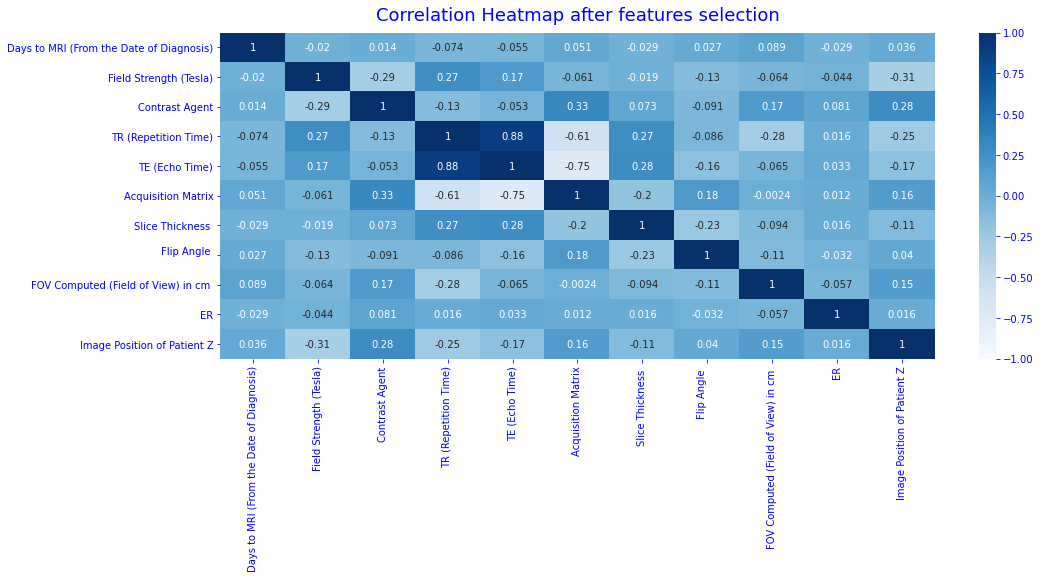

In [156]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(mri_df.corr(), vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation Heatmap after features selection', fontdict={'fontsize':18}, pad=12,color="b");
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
#plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

### Imaging features

In [158]:
images_df.shape

(922, 529)

In [157]:
# We only have numerical data
print(images_df._get_numeric_data().shape==images_df.shape)
print('There are no null columns :',not(images_df.dropna().shape==images_df.shape))

True
There are no null columns : True


In [161]:
nan_cols = images_df.columns[images_df.isna().any()].tolist()
print("Columns with nan values:",nan_cols)
# GET NUMBER OF NAN VALUES PER COLUMN
data_nan = images_df[nan_cols].isna().sum()*100/images_df[nan_cols].shape[0]

Columns with nan values: ['BEVR_Tumor', 'BEDR1_Tumor', 'BEDR2_Tumor', 'MF_Tumor', 'ASD_Tumor', 'Volume_cu_mm_Tumor', 'Grouping_based_mean_of_peak_enhancement_slope_3D_tumor_Group_1', 'Grouping_based_mean_of_peak_enhancement_slope_3D_tumor_Group_3', 'Grouping_based_variance_of_peak_enhancement_slope_3D_tumor_Group_1', 'Grouping_based_variance_of_peak_enhancement_slope_3D_tumor_Group_3', 'Grouping_based_mean_of_washin_slope_3D_tumor_Group_1', 'Grouping_based_mean_of_washin_slope_3D_tumor_Group_3', 'Grouping_based_variance_of_washin_slope_3D_tumor_Group_1', 'Grouping_based_variance_of_washin_slope_3D_tumor_Group_3', 'Grouping_based_mean_of_washout_slope_3D_tumor_Group_1', 'Grouping_based_variance_of_washout_slope_3D_tumor_Group_1', 'Grouping_based_mean_of_peak_enhancement_slope_2D_tumorSlice_Group_1', 'Grouping_based_mean_of_peak_enhancement_slope_2D_tumorSlice_Group_2', 'Grouping_based_mean_of_peak_enhancement_slope_2D_tumorSlice_Group_3', 'Grouping_based_variance_of_peak_enhancement_slo

In [162]:
# Percentage of nan values per column
data_nan.sort_values(ascending=False).head()

Grouping_based_variance_of_peak_enhancement_slope_2D_tumorSlice_Group_1    4.772234
Grouping_based_variance_of_washout_slope_2D_tumorSlice_Group_1             4.772234
Grouping_based_mean_of_washin_slope_2D_tumorSlice_Group_1                  4.772234
Grouping_based_variance_of_washin_slope_2D_tumorSlice_Group_1              4.772234
Grouping_based_mean_of_washout_slope_2D_tumorSlice_Group_1                 4.772234
dtype: float64

<Figure size 720x360 with 0 Axes>

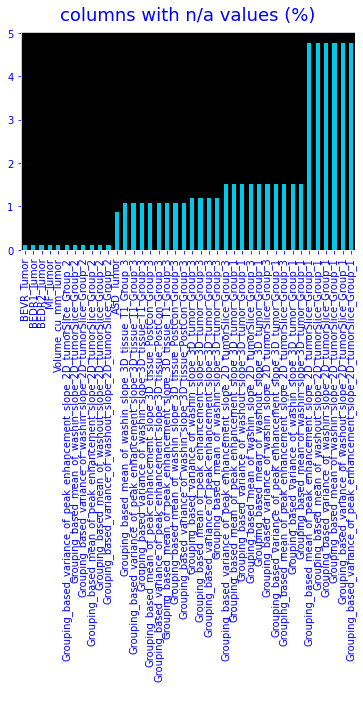

In [163]:
figure=plt.figure(figsize=(10,5))
data_nan.to_frame().sort_values(by=0).reset_index().plot(kind="bar",x='index',title="Nan values percentage per column",color=lunit_colors[0],legend=False)
plt.title('columns with n/a values (%)', fontdict={'fontsize':18}, pad=12,color="b")
plt.savefig("images/nan_values_mri.png")
plt.show()


All columns with nan values have less that 5% of non existing values so we might keep all columns for now

In [164]:
# ADD Target to images
data= pd.concat([clinical_df[target],images_df],axis=1)

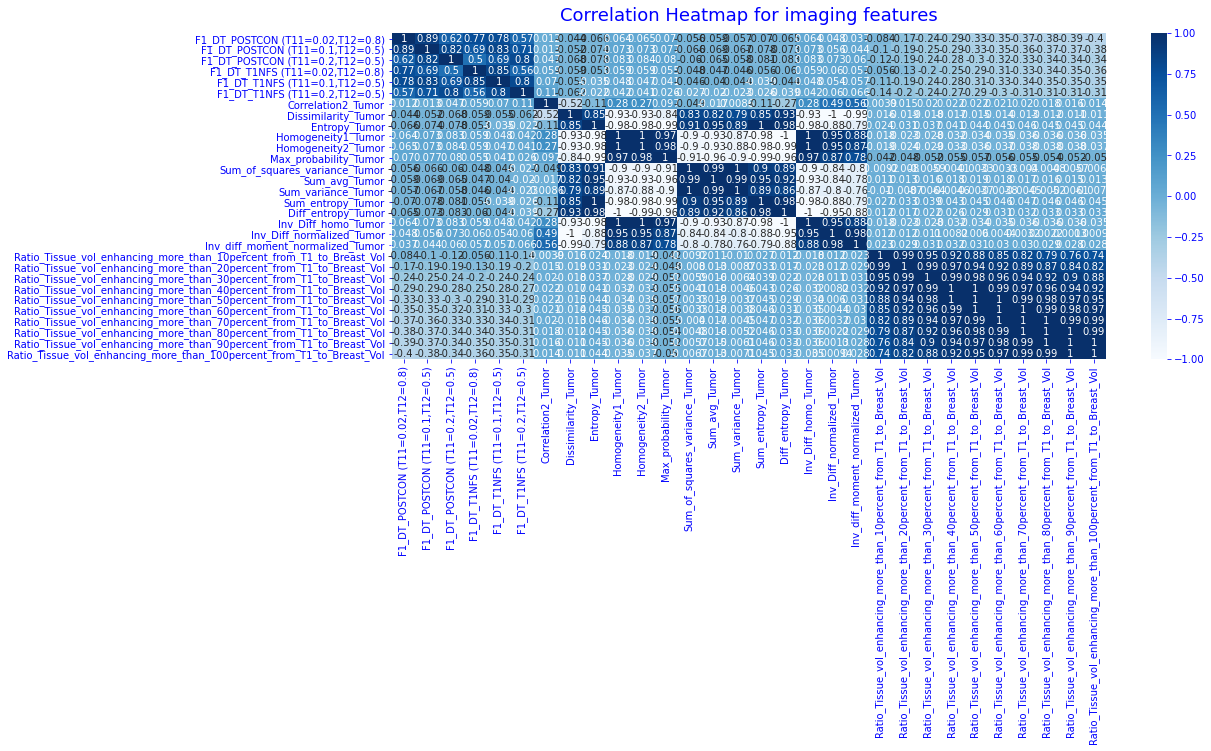

In [165]:
# Remove First very correlated data 
# Create correlation matrix
corr_matrix = data.drop(columns=target).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

corr_mat = data[to_drop[:30]].corr()
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_mat , vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation Heatmap for imaging features', fontdict={'fontsize':18}, pad=12,color="b");
plt.savefig("images/heatmap_imaging.png")

In [166]:
print('we removed',len(to_drop), "feature")

data.drop(to_drop, axis=1, inplace=True)


we removed 296 feature


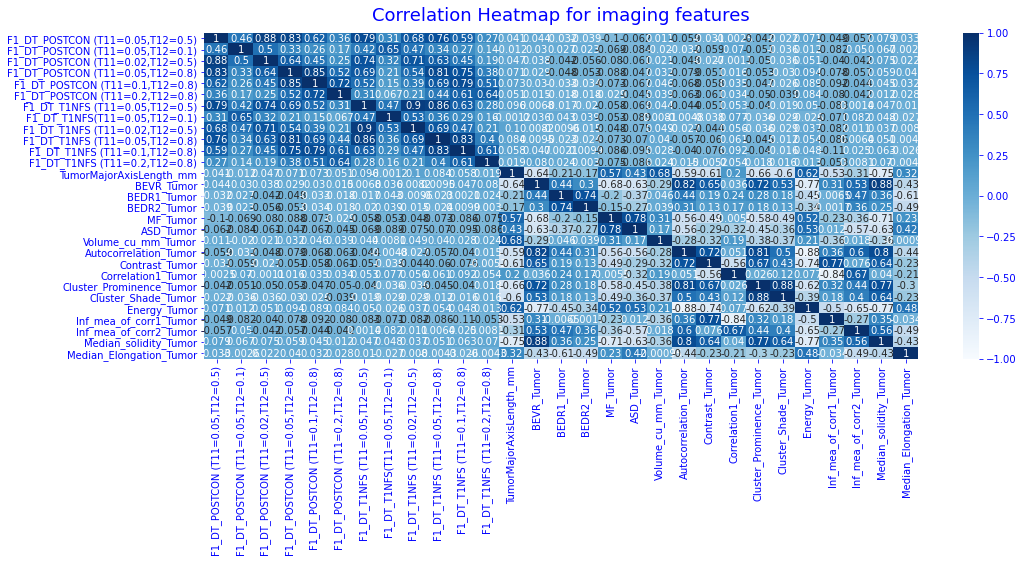

In [167]:

corr_mat = data[data.columns[:30]].corr()
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_mat , vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Correlation Heatmap for imaging features', fontdict={'fontsize':18}, pad=12,color="b");
#plt.savefig("images/heatmap_imaging.png")

# Deal with nan values

In [168]:
# Fill nan values with median 
data= data.fillna(data.median()) 
data.shape

(922, 234)

### Features selection

There are two popular feature selection techniques that can be used for numerical input data and a categorical (class) target variable.
An F-statistic, or F-test, is a class of statistical tests that calculate the ratio between variances values, such as the variance from two different samples or the explained and unexplained variance by a statistical test, like ANOVA. The ANOVA method is a type of F-statistic referred to here as an ANOVA f-test.

Feature 0: 5.179337
Feature 1: 0.866553
Feature 2: 4.471180
Feature 3: 3.936213
Feature 4: 0.874841
Feature 5: 0.124033
Feature 6: 5.270715
Feature 7: 3.564985
Feature 8: 4.259259
Feature 9: 3.983305
Feature 10: 1.808264
Feature 11: 0.518815
Feature 12: 21.893170
Feature 13: 7.928346
Feature 14: 0.144830
Feature 15: 3.670763
Feature 16: 1.808561
Feature 17: 0.695145
Feature 18: 31.164530
Feature 19: 8.861266
Feature 20: 14.882707
Feature 21: 12.796414
Feature 22: 16.896728
Feature 23: 9.317787
Feature 24: 3.075808
Feature 25: 15.397321
Feature 26: 1.439957
Feature 27: 9.399535
Feature 28: 0.335129
Feature 29: 3.381099
Feature 30: 4.989681
Feature 31: 12.477120
Feature 32: 10.430998
Feature 33: 0.733970
Feature 34: 3.033453
Feature 35: 7.068455
Feature 36: 1.007917
Feature 37: 0.613221
Feature 38: 0.803242
Feature 39: 0.092631
Feature 40: 1.429238
Feature 41: 0.590219
Feature 42: 0.348830
Feature 43: 1.448649
Feature 44: 0.491841
Feature 45: 2.949100
Feature 46: 1.781503
Feature 47: 1.3

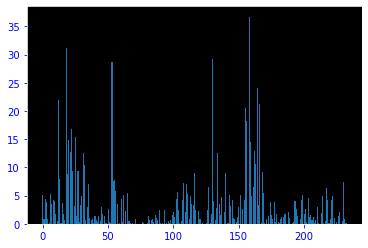

In [169]:
# configure to select all features
fs = SelectKBest(score_func=f_classif, k='all')
# learn relationship from training data
fs.fit(data.drop(columns=target),data[target])
# transform train input data
X_fs = fs.transform(data.drop(columns=target))


keep_cols=[]
cols=data.drop(columns=target).columns

# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
    # We keep columns with statistical value superior than the median 
    if fs.scores_[i]>np.median(fs.scores_):
        keep_cols.append(cols[i])
        
        
features_sort= sorted(range(len(fs.scores_)), key=lambda k: fs.scores_[k])
top6_cols=[cols[x] for x in features_sort[-6:]]
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()


In [170]:
print("Final selection contains",len(keep_cols),"columns")
data=data[[target]+keep_cols]

Final selection contains 116 columns


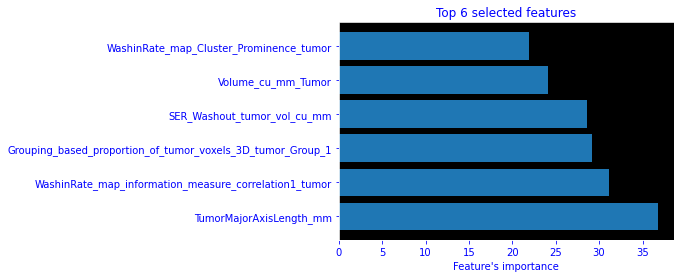

In [171]:

plt.barh(top6_cols,-np.sort(-fs.scores_)[:6])
plt.xlabel("Feature's importance",color="b")
plt.title("Top 6 selected features",color="b")
plt.savefig("images/anova.png")

### Outliers handling

In [172]:
# Quantile calculation
Q1 = data.drop(columns=target).quantile(0.25)
Q3 = data.drop(columns=target).quantile(0.75)
IQR = Q3 - Q1
# Find number of outliers per columns
outliers_per_col=((data.drop(columns=target) < (Q1 - 1.5 * IQR)) | (data.drop(columns=target) > (Q3 + 1.5 * IQR))).sum()
# Keep only those with less than 20% of the rows as outliers 
outliers_per_col=outliers_per_col[outliers_per_col>0.2*data.shape[0]]
print("we remove",len(outliers_per_col),"columns")


we remove 2 columns


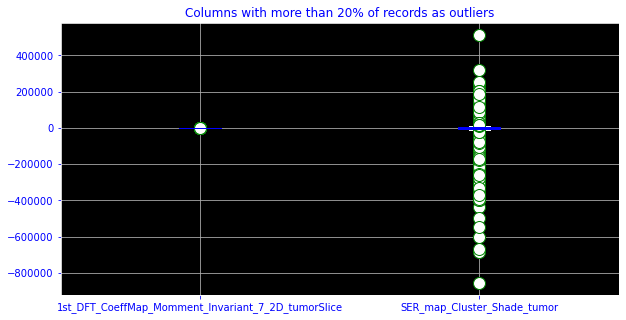

In [173]:
# Keep only those with more than one 
props = dict(boxes="Blue", whiskers="Orange", medians="Blue", caps="White")
# plot. Set color of marker edge
flierprops = dict(marker='o', markerfacecolor='w', markersize=12,
                  linestyle='none', markeredgecolor='g')

bp_dict = data[outliers_per_col.index].boxplot(figsize=(10,5),grid=True,color=props,patch_artist = True,flierprops=flierprops).set_title("Outliers for"+", ".join(list(outliers_per_col.index)))
plt.title("Columns with more than 20% of records as outliers",color="b")
plt.savefig("images/outliers.png")

In [174]:
# remove columns
data.drop(columns=outliers_per_col.index,inplace=True)
print("data's shape is :",data.shape)

data's shape is : (922, 115)


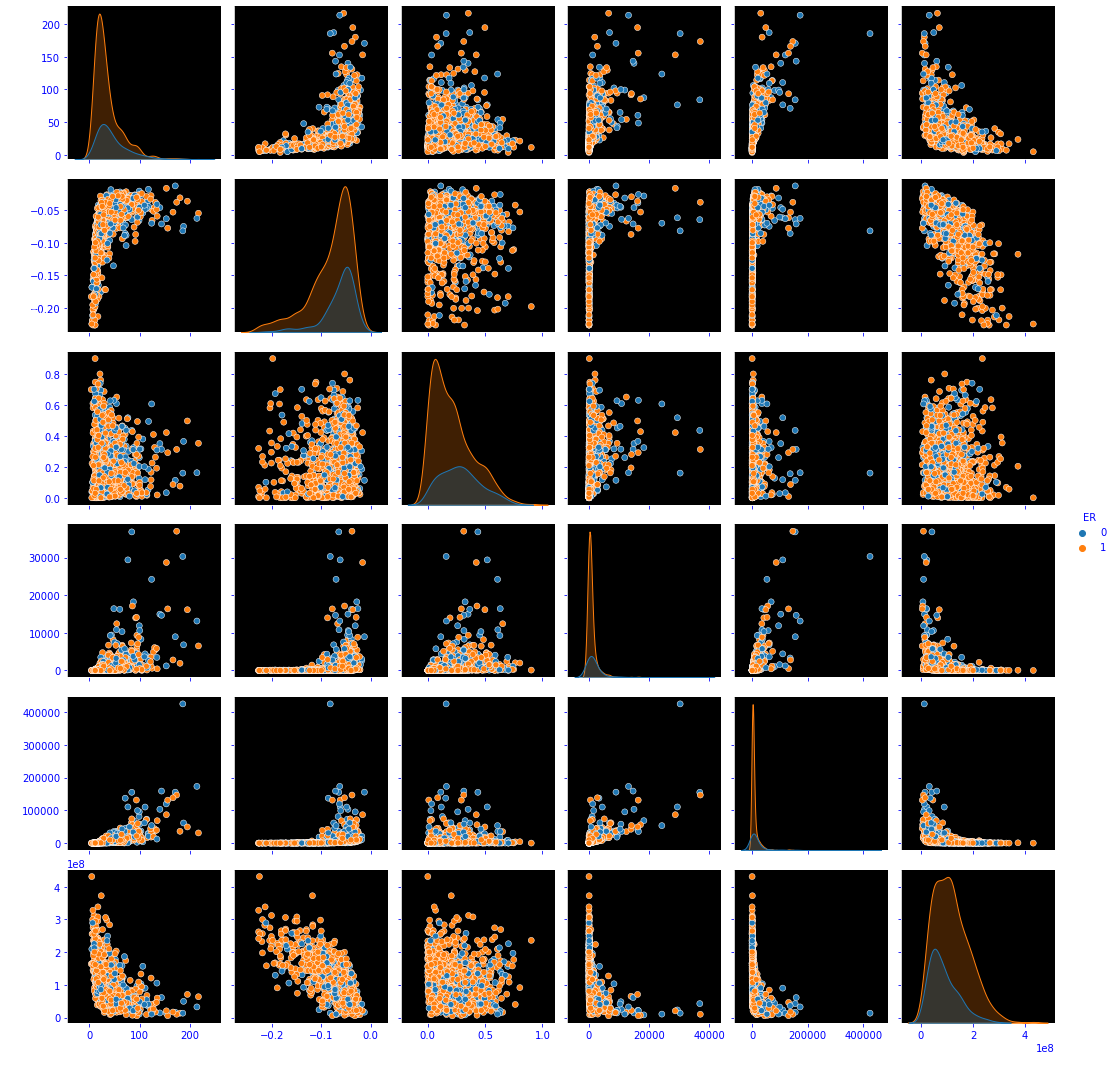

In [175]:
# Let's see paiwise distribution 
# choose  5 most f-score features
pairsns_pos= sns.pairplot(data[[target]+top5_cols],hue=target)


# Classification task

In [176]:
data.describe()

ER  F1_DT_POSTCON (T11=0.05,T12=0.5)  \
count  922.000000                        922.000000   
mean     0.744035                          0.419264   
std      0.436639                          0.309132   
min      0.000000                          0.056549   
25%      0.000000                          0.170292   
50%      1.000000                          0.291212   
75%      1.000000                          0.635994   
max      1.000000                          1.000000   

       F1_DT_POSTCON (T11=0.02,T12=0.5)  F1_DT_POSTCON (T11=0.05,T12=0.8)  \
count                        922.000000                        922.000000   
mean                           0.212384                          0.649706   
std                            0.234666                          0.325760   
min                            0.022620                          0.068978   
25%                            0.068117                          0.330683   
50%                            0.116485                          0.668286   
75%                            0.254397                          1.000000   
max                            1.000000                          1.000000   

       F1_DT_T1NFS (T11=0.05,T12=0.5)  F1_DT_T1NFS(T11=0.05,T12=0.1)  \
count                      922.000000                     922.000000   
mean                         0.383367                       0.090720   
std                          0.252176                       0.051710   
min                          0.072222                       0.035837   
25%                          0.197328                       0.069727   
50%                          0.296516                       0.083980   
75%                          0.492885                       0.101025   
max                          1.000000                       1.000000   

       F1_DT_T1NFS (T11=0.02,T12=0.5)  F1_DT_T1NFS (T11=0.05,T12=0.8)  \
count                      922.000000                      922.000000   
mean                         0.173674                        0.618963   
std                          0.165571                        0.291910   
min                          0.028889                        0.094161   
25%                          0.078931                        0.352374   
50%                          0.118607                        0.577977   
75%                          0.197154                        0.969749   
max                          1.000000                        1.000000   

       F1_DT_T1NFS (T11=0.1,T12=0.8)  TumorMajorAxisLength_mm  BEVR_Tumor  \
count                     922.000000               922.000000  922.000000   
mean                        0.847826                38.335277    0.308947   
std                         0.207502                30.771342    0.149618   
min                         0.188322                 3.436246    0.029757   
25%                         0.711106                17.721480    0.185648   
50%                         0.993818                28.319888    0.298022   
75%                         1.000000                47.680554    0.418379   
max                         1.000000               216.747539    0.726297   

       BEDR2_Tumor    MF_Tumor  Volume_cu_mm_Tumor  Autocorrelation_Tumor  \
count   922.000000  922.000000          922.000000             922.000000   
mean      0.762097    0.060747         9908.083559              83.647911   
std       0.125644    0.026138        24102.890117              57.141519   
min       0.285013    0.000000           25.077509               4.146450   
25%       0.686103    0.043174          995.567888              37.025657   
50%       0.782424    0.056136         2833.614621              72.245299   
75%       0.855239    0.073916         8237.936780             121.454217   
max       0.982300    0.176232       424316.270160             318.042989   

       Contrast_Tumor  Correlation1_Tumor  Cluster_Prominence_Tumor  \
count      922.000000          922.000000                92

In [177]:
# let's split test and train
train,test = data.drop(list(test_df.index),axis=0),data.loc[list(test_df.index)]
X_train,X_test,y_train,y_test = train.drop(columns=[target]), test.drop(columns=[target]), train[target], test[target]

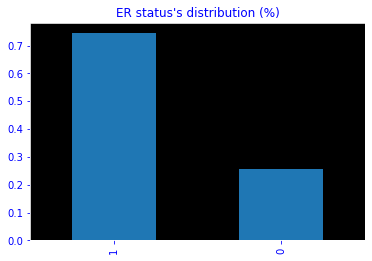

In [182]:
(y_train.value_counts()/y_train.shape[0]).plot(kind="bar",title="target's distribution (%)")
plt.title("ER status's distribution (%)",color="b")
plt.savefig("images/target_dist.png")

##### The target data is imbalanced since we have 75% of the data is postive 

WE suffer from the problem of the curse of dimensionality that the problem of searching through a space much more difficult, and effects the majority of algorithms that "learn" through partitioning their vector space. The higher the dimensionality of our optimization problem the more data we need to fill the space that we are optimizing over.


Linear models suffer immensely from the curse of dimensionality, so we are going to avoid logistic regression, also Decision trees also suffer from the curse of dimensionality, On the other hand, Random Forests use a collection of decision trees to make their predictions. But instead of using all the features of your problem, individual trees only use a subset of the features. This minimizes the space that each tree is optimizing over and can help combat the problem of the curse of dimensionality.

# PCA : dimention reduction

I think you just answered yourself. In general RF are not good in high dimensional settings or when you have more features than samples, therefore reducing your features is a must

In [183]:
# Performing PCA 
for com in tqdm([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]):
    pca = PCA(n_components=com)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    # The PCA class contains explained_variance_ratio_ which returns the variance caused by each of the principal components.
    explained_variance = pca.explained_variance_ratio_
    explained_variance
    rfc = RandomForestClassifier(criterion='gini', max_depth= 8,max_features= 'auto',n_estimators= 200)
    rfc.fit(X_train_pca,y_train)
    # get predictions (probabilitites and output with threshold )
    pred_proba_pca = rfc.predict_proba(X_test_pca)
    predictions_pca = rfc.predict(X_test_pca)
    class_probabilities = pred_proba_pca 
    preds = class_probabilities[:, 1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    # Printing AUC
    print("AUC for our classifier is:",roc_auc," for ",com,"components")

  0%|          | 0/11 [00:00<?, ?it/s]

AUC for our classifier is: 0.5920591889754886  for  0.1 components
AUC for our classifier is: 0.5956173048684062  for  0.2 components
AUC for our classifier is: 0.5958432169885914  for  0.3 components
AUC for our classifier is: 0.5885857901276403  for  0.4 components
AUC for our classifier is: 0.597226928724726  for  0.5 components
AUC for our classifier is: 0.5971139726646335  for  0.6 components
AUC for our classifier is: 0.5968033434993787  for  0.7 components
AUC for our classifier is: 0.5918050378402802  for  0.8 components
AUC for our classifier is: 0.5915508867050716  for  0.9 components
AUC for our classifier is: 0.5792669151699988  for  0.95 components
AUC for our classifier is: 0.5886987461877329  for  0.99 components


In [192]:
#  PCA performs best with a normalized feature set. We will perform standard scalar normalization to normalize our feature set
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [193]:
# Performing PCA 
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
# The PCA class contains explained_variance_ratio_ which returns the variance caused by each of the principal components.
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.98528956, 0.01366253])

It can be seen that first principal component is responsible for 13 % variance.

##  Baseline model: Random forest ( bagging on decision trees)

In [195]:
rf = RandomForestClassifier(random_state = 42)
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy'],
   
}

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [196]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier(class_weight={0: 10,1:2},criterion='entropy',max_depth= 6, max_features= 'auto',n_estimators= 200)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, verbose=10)
                              
# Fit the random search model
CV_rfc.fit(X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200
[CV 1/5; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.548 total time=   0.6s
[CV 2/5; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200
[CV 2/5; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.669 total time=   0.4s
[CV 3/5; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200
[CV 3/5; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.602 total time=   0.7s
[CV 4/5; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200
[CV 4/5; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.577 total time=   1.1s
[CV 5/5; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200
[CV 5/5; 1/60] END criterion=gini, max_d

[CV 1/5; 9/60] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200;, score=0.613 total time=   1.2s
[CV 2/5; 9/60] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200
[CV 2/5; 9/60] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200;, score=0.726 total time=   1.1s
[CV 3/5; 9/60] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200
[CV 3/5; 9/60] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200;, score=0.642 total time=   1.0s
[CV 4/5; 9/60] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200
[CV 4/5; 9/60] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200;, score=0.634 total time=   1.1s
[CV 5/5; 9/60] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200
[CV 5/5; 9/60] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200;, score=0.667 total time=   1.2s
[CV 1/5; 10/60] START criterion=gini, max_depth=5, max_features=sqrt, n

[CV 2/5; 17/60] END criterion=gini, max_depth=6, max_features=log2, n_estimators=200;, score=0.742 total time=   0.9s
[CV 3/5; 17/60] START criterion=gini, max_depth=6, max_features=log2, n_estimators=200
[CV 3/5; 17/60] END criterion=gini, max_depth=6, max_features=log2, n_estimators=200;, score=0.707 total time=   0.9s
[CV 4/5; 17/60] START criterion=gini, max_depth=6, max_features=log2, n_estimators=200
[CV 4/5; 17/60] END criterion=gini, max_depth=6, max_features=log2, n_estimators=200;, score=0.659 total time=   0.9s
[CV 5/5; 17/60] START criterion=gini, max_depth=6, max_features=log2, n_estimators=200
[CV 5/5; 17/60] END criterion=gini, max_depth=6, max_features=log2, n_estimators=200;, score=0.748 total time=   0.9s
[CV 1/5; 18/60] START criterion=gini, max_depth=6, max_features=log2, n_estimators=500
[CV 1/5; 18/60] END criterion=gini, max_depth=6, max_features=log2, n_estimators=500;, score=0.653 total time=   2.4s
[CV 2/5; 18/60] START criterion=gini, max_depth=6, max_feature

[CV 2/5; 25/60] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.750 total time=   1.5s
[CV 3/5; 25/60] START criterion=gini, max_depth=8, max_features=auto, n_estimators=200
[CV 3/5; 25/60] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.732 total time=   1.5s
[CV 4/5; 25/60] START criterion=gini, max_depth=8, max_features=auto, n_estimators=200
[CV 4/5; 25/60] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.748 total time=   1.2s
[CV 5/5; 25/60] START criterion=gini, max_depth=8, max_features=auto, n_estimators=200
[CV 5/5; 25/60] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.740 total time=   1.3s
[CV 1/5; 26/60] START criterion=gini, max_depth=8, max_features=auto, n_estimators=500
[CV 1/5; 26/60] END criterion=gini, max_depth=8, max_features=auto, n_estimators=500;, score=0.718 total time=   3.4s
[CV 2/5; 26/60] START criterion=gini, max_depth=8, max_feature

[CV 2/5; 33/60] END criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.629 total time=   1.4s
[CV 3/5; 33/60] START criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200
[CV 3/5; 33/60] END criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.626 total time=   1.2s
[CV 4/5; 33/60] START criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200
[CV 4/5; 33/60] END criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.593 total time=   1.5s
[CV 5/5; 33/60] START criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200
[CV 5/5; 33/60] END criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.642 total time=   1.3s
[CV 1/5; 34/60] START criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=500
[CV 1/5; 34/60] END criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=500;, score=0.581 total time=   2.0s
[CV 2/5; 34/60] START criterion=ent

[CV 1/5; 41/60] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=200;, score=0.605 total time=   0.7s
[CV 2/5; 41/60] START criterion=entropy, max_depth=5, max_features=log2, n_estimators=200
[CV 2/5; 41/60] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=200;, score=0.710 total time=   1.1s
[CV 3/5; 41/60] START criterion=entropy, max_depth=5, max_features=log2, n_estimators=200
[CV 3/5; 41/60] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=200;, score=0.667 total time=   1.2s
[CV 4/5; 41/60] START criterion=entropy, max_depth=5, max_features=log2, n_estimators=200
[CV 4/5; 41/60] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=200;, score=0.667 total time=   1.1s
[CV 5/5; 41/60] START criterion=entropy, max_depth=5, max_features=log2, n_estimators=200
[CV 5/5; 41/60] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=200;, score=0.675 total time=   1.1s
[CV 1/5; 42/60] START criterion=ent

[CV 5/5; 48/60] END criterion=entropy, max_depth=6, max_features=log2, n_estimators=500;, score=0.748 total time=   3.2s
[CV 1/5; 49/60] START criterion=entropy, max_depth=7, max_features=auto, n_estimators=200
[CV 1/5; 49/60] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=200;, score=0.661 total time=   1.8s
[CV 2/5; 49/60] START criterion=entropy, max_depth=7, max_features=auto, n_estimators=200
[CV 2/5; 49/60] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=200;, score=0.750 total time=   1.7s
[CV 3/5; 49/60] START criterion=entropy, max_depth=7, max_features=auto, n_estimators=200
[CV 3/5; 49/60] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=200;, score=0.732 total time=   1.7s
[CV 4/5; 49/60] START criterion=entropy, max_depth=7, max_features=auto, n_estimators=200
[CV 4/5; 49/60] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=200;, score=0.715 total time=   1.7s
[CV 5/5; 49/60] START criterion=ent

[CV 4/5; 56/60] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=500;, score=0.772 total time=   3.3s
[CV 5/5; 56/60] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=500
[CV 5/5; 56/60] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=500;, score=0.764 total time=   5.6s
[CV 1/5; 57/60] START criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200
[CV 1/5; 57/60] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200;, score=0.702 total time=   1.9s
[CV 2/5; 57/60] START criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200
[CV 2/5; 57/60] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200;, score=0.766 total time=   1.7s
[CV 3/5; 57/60] START criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200
[CV 3/5; 57/60] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200;, score=0.748 total time=   1.0s
[CV 4/5; 57/60] START criterion=ent

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 10, 1: 2},
                                              criterion='entropy', max_depth=6,
                                              n_estimators=200),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             verbose=10)

In [38]:
#print('best set of parameters is: ',CV_rfc.best_params_)
from sklearn.metrics import precision_recall_curve


# Evaluate performances

#### Confusion matrix, Auc /Roc Curve, F1-SCORE

best set of parameters is:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
==========CONFUSION MATRIX==========


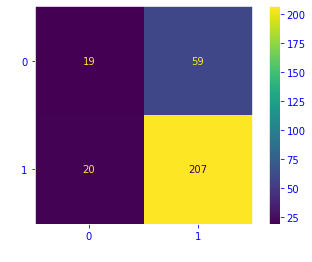

==========CLASSIFICATION REPORT==========
              precision    recall  f1-score   support

           0       0.49      0.24      0.32        78
           1       0.78      0.91      0.84       227

    accuracy                           0.74       305
   macro avg       0.63      0.58      0.58       305
weighted avg       0.70      0.74      0.71       305

==========AUC/ROC CURVE==========
AUC for our classifier is: 0.6604540833615724


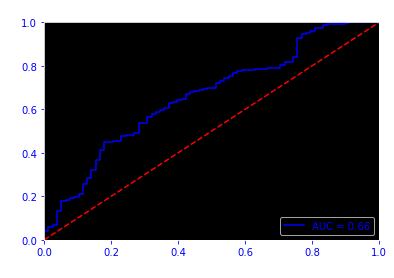

==========PR CURVE==========
Logistic: f1=0.840 auc=0.840


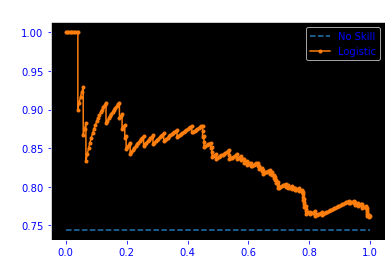

In [197]:
print('best set of parameters is: ',CV_rfc.best_params_)

evaluate(CV_rfc,X_test,y_test)

#### comparision with Lunit predictions

==========AUC/ROC CURVE==========
AUC for our classifier is: 0.617671975601491


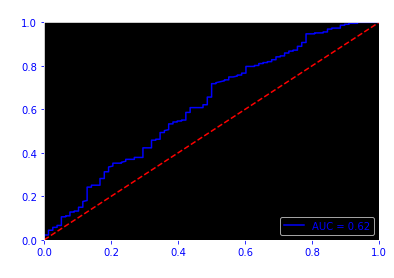

==========PR CURVE==========
Logistic: auc=0.807


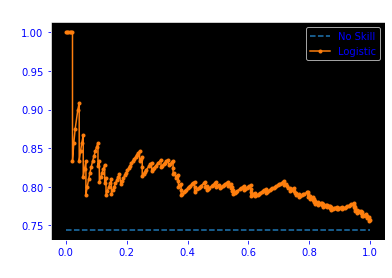

In [198]:
#print('best set of parameters is: ',CV_rfc.best_params_)
# Extract probabilities from test file
lr_probs =  test_df.values
evaluate_test(lr_probs,y_test)

so we notice that we have the same performances as Lunit predictions so we need to enhance the model's performances

##  Baseline model: Random forest ( bagging on decision trees) + pca


==========CONFUSION MATRIX==========


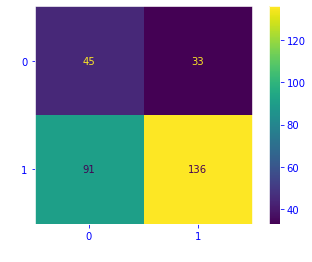

==========CLASSIFICATION REPORT==========
              precision    recall  f1-score   support

           0       0.33      0.58      0.42        78
           1       0.80      0.60      0.69       227

    accuracy                           0.59       305
   macro avg       0.57      0.59      0.55       305
weighted avg       0.68      0.59      0.62       305

==========AUC/ROC CURVE==========
AUC for our classifier is: 0.5701174743024964


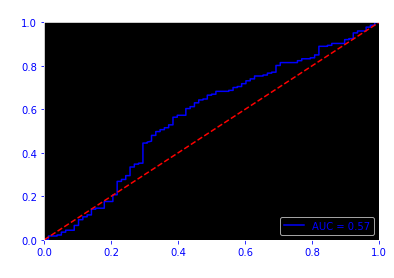

==========PR CURVE==========
Logistic: f1=0.687 auc=0.760


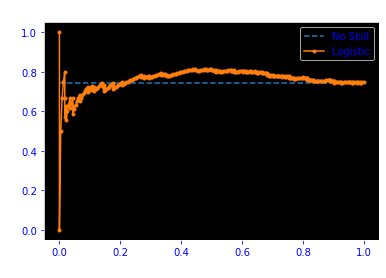

In [199]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier(class_weight={0: 10,1:2},criterion='gini',max_depth= 8, max_features= 'log2',n_estimators= 500)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
CV_rfc = rfc #GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, verbose=10)
                              
# Fit the random search model
CV_rfc.fit(X_train_pca,y_train)
# predict class value
evaluate(CV_rfc,X_test_pca,y_test)

# RF+ pca+smote


In [200]:
# ADD UNDERSAMPLER
# fit and apply the transform
oversample = SMOTE(sampling_strategy=1)
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)

==========CONFUSION MATRIX==========


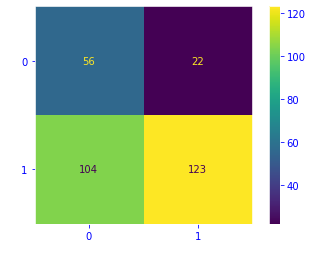

==========CLASSIFICATION REPORT==========
              precision    recall  f1-score   support

           0       0.35      0.72      0.47        78
           1       0.85      0.54      0.66       227

    accuracy                           0.59       305
   macro avg       0.60      0.63      0.57       305
weighted avg       0.72      0.59      0.61       305

==========AUC/ROC CURVE==========
AUC for our classifier is: 0.6613012538122671


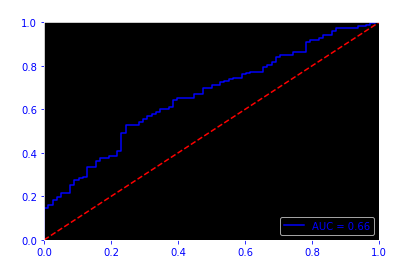

==========PR CURVE==========
Logistic: f1=0.661 auc=0.857


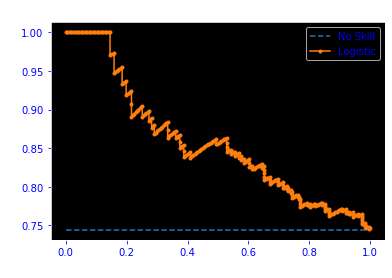

In [201]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier(class_weight={0: 10,1:2},criterion='gini',max_depth= 8, max_features= 'log2',n_estimators= 500)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
CV_rfc = rfc #GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, verbose=10)
                              
# Fit the random search model
CV_rfc.fit(X_train_sm,y_train_sm)
# predict class value
evaluate(CV_rfc,X_test,y_test)

# XGBOOST: BOOSTING model 

In [202]:
# A parameter grid for XGBoost
xg_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'scale_pos_weight':[0.1,0.2,1,10,20,40,90,1]
        }
xgb = XGBClassifier(learning_rate=0.1, n_estimators=400, objective='binary:logistic',
                    silent=True, nthread=1)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[11:33:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:33:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
==========CONFUSION MATRIX==========


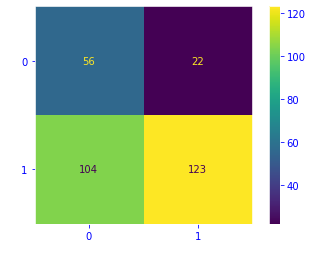

==========CLASSIFICATION REPORT==========
              precision    recall  f1-score   support

           0       0.35      0.72      0.47        78
           1       0.85      0.54      0.66       227

    accuracy                           0.59       305
   macro avg       0.60      0.63      0.57       305
weighted avg       0.72      0.59      0.61       305

==========AUC/ROC CURVE==========
AUC for our classifier is: 0.6613012538122671


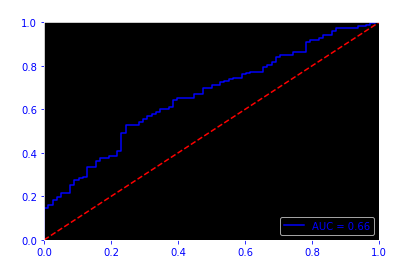

==========PR CURVE==========
Logistic: f1=0.661 auc=0.857


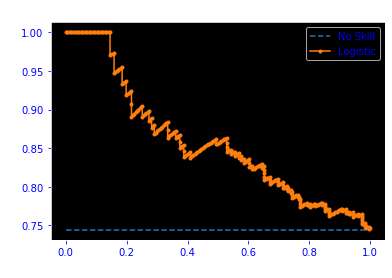

In [203]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=xg_params, n_iter=param_comb, scoring='balanced_accuracy', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3 ,random_state=1001 )

random_search.fit(X_train, y_train)
# Evaluate
evaluate(CV_rfc,X_test,y_test)

## XGBOOST: BOOSTING model with pca

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[11:33:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:33:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
==========CONFUSION MATRIX==========


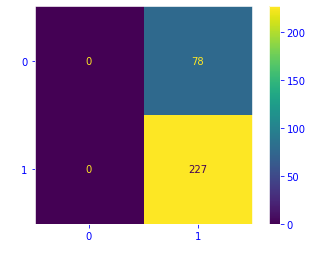

==========CLASSIFICATION REPORT==========
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.74      1.00      0.85       227

    accuracy                           0.74       305
   macro avg       0.37      0.50      0.43       305
weighted avg       0.55      0.74      0.64       305

==========AUC/ROC CURVE==========
AUC for our classifier is: 0.5907319552694003


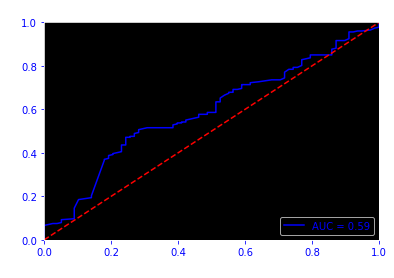

==========PR CURVE==========
Logistic: f1=0.853 auc=0.811


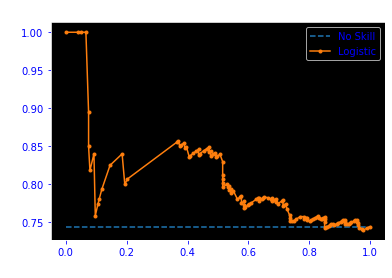

In [204]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=xg_params, n_iter=param_comb, scoring='precision', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3 ,random_state=1001 )
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
random_search.fit(X_train_pca, y_train)

# Evaluate model 
# AUC-ROC Curve is a performance metric that is used to measure the performance for the classification model at different threshold values.
evaluate(random_search,X_test_pca,y_test)

### Xgboost+smote

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[11:34:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:34:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
==========CONFUSION MATRIX==========


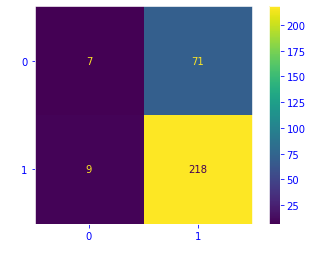

==========CLASSIFICATION REPORT==========
              precision    recall  f1-score   support

           0       0.44      0.09      0.15        78
           1       0.75      0.96      0.84       227

    accuracy                           0.74       305
   macro avg       0.60      0.53      0.50       305
weighted avg       0.67      0.74      0.67       305

==========AUC/ROC CURVE==========
AUC for our classifier is: 0.6501186038630973


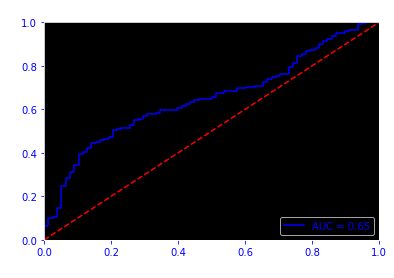

==========PR CURVE==========
Logistic: f1=0.845 auc=0.854


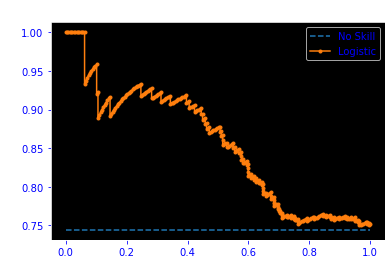

In [205]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=xg_params, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=skf.split(X_train_sm, y_train_sm), verbose=3 ,random_state=1001 )

random_search.fit(X_train_sm, y_train_sm)
# Evaluate model 
# AUC-ROC Curve is a performance metric that is used to measure the performance for the classification model at different threshold values.
evaluate(random_search,X_test,y_test)

xgboost seems to overfit on the major class when associated with pca or smote

# Clinical features

In [206]:
data_all = pd.concat([images_df,demo_df,mri_df.drop(columns=target)],axis=1)
print(data_all.shape)


(922, 545)


In [207]:
# encode categorical features
for col in ["Race and Ethnicity",'Monopose_age']:
    data_all = pd.concat([data_all,pd.get_dummies(data_all[col],prefix="Race")],axis=1)
    data_all.drop(columns=[col],inplace=True)

In [208]:
# Quantile calculation
Q1 = data_all.drop(columns=target).quantile(0.25)
Q3 = data_all.drop(columns=target).quantile(0.75)
IQR = Q3 - Q1
# Find number of outliers per columns
outliers_per_col=((data_all.drop(columns=target) < (Q1 - 1.5 * IQR)) | (data_all.drop(columns=target) > (Q3 + 1.5 * IQR))).sum()
# Keep only those with less than 20% of the rows as outliers 
outliers_per_col=outliers_per_col[outliers_per_col>0.2*data_all.shape[0]]
print("we remove",len(outliers_per_col),"columns")
# remove columns
data_all.drop(columns=outliers_per_col.index,inplace=True)
print("data's shape is :",data_all.shape)

we remove 12 columns
data's shape is : (922, 542)


In [38]:
# Drop very correlated features
cor_matrix = data_all.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
data_all = data_all.drop(data_all[to_drop], axis=1)
print("data's shape is :",data_all.shape)

data's shape is : (922, 252)


In [209]:
train,test = data_all.drop(list(test_df.index),axis=0),data_all.loc[list(test_df.index)]
corr_target=train.corr()[[target]].abs()
selected_columns=list(corr_target[corr_target[target]>=0.1].index)
train,test = train[selected_columns],test[selected_columns]


In [210]:
medians=train.median()
train,test=train.fillna(medians),test.fillna(medians)


In [211]:
X_train,X_val,y_train,y_val=train_test_split( train.drop(columns=[target]), train[target], test_size=0.20, random_state=42)
X_test,y_test = test.drop(columns=[target]), test[target]
#  PCA performs best with a normalized feature set. We will perform standard scalar normalization to normalize our feature set
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
X_val_sc = sc.transform(X_val)

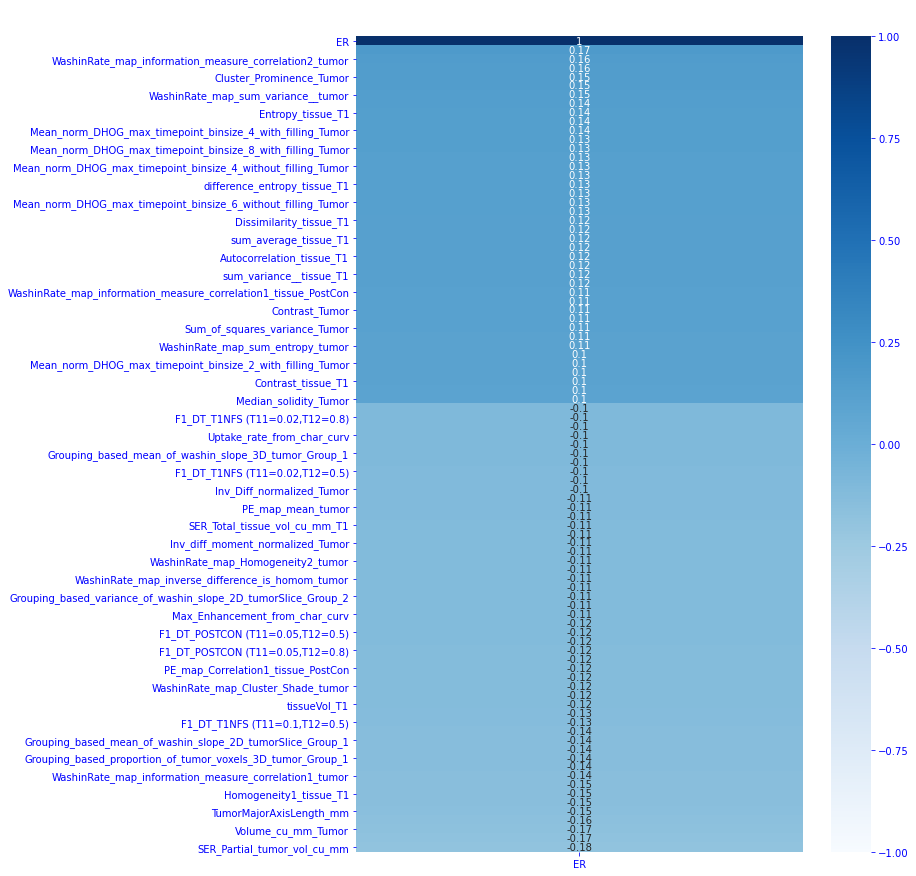

In [212]:
plt.figure(figsize=(10, 15))
heatmap = sns.heatmap(train.corr()[[target]].sort_values(by=target, ascending=False), vmin=-1, vmax=1, annot=True, cmap='Blues')
heatmap.set_title('Features Correlating with '+target, fontdict={'fontsize':18}, pad=16);

In [213]:
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
#  PCA performs best with a normalized feature set. We will perform standard scalar normalization to normalize our feature set
print(y_train.value_counts())
#pca = PCA(n_components=0.98)
X_train_pca =X_train_sc# pca.fit_transform(X_train_sc)
X_test_pca =X_test_sc #pca.transform(X_test_sc)
X_val_pca =X_val_sc 
oversample = SMOTETomek(tomek=TomekLinks(sampling_strategy='auto'))
X_train_sm, y_train_sm =oversample.fit_resample(X_train_pca, y_train)#X_train_pca,y_train 
print(y_train_sm.value_counts())
print(X_train_sm.shape)


1.0    367
0.0    126
Name: ER, dtype: int64
0.0    367
1.0    363
Name: ER, dtype: int64
(730, 90)


## Xgboost: pca+{image features+ clinical features}

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[11:34:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
==========CONFUSION MATRIX==========


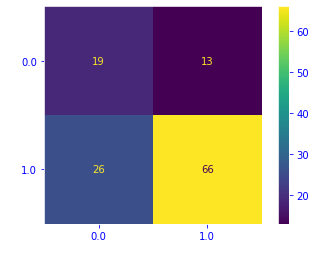

==========CLASSIFICATION REPORT==========
              precision    recall  f1-score   support

         0.0       0.42      0.59      0.49        32
         1.0       0.84      0.72      0.77        92

    accuracy                           0.69       124
   macro avg       0.63      0.66      0.63       124
weighted avg       0.73      0.69      0.70       124

==========AUC/ROC CURVE==========
AUC for our classifier is: 0.6762907608695652


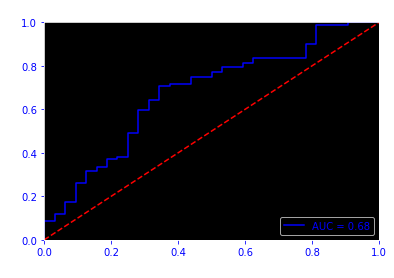

==========PR CURVE==========
Logistic: f1=0.772 auc=0.847


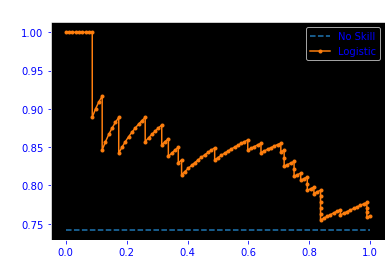

In [214]:
folds = 3
param_comb = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
# A parameter grid for XGBoost
xg_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.4,0.6, 0.8, 1.0],
        'colsample_bytree': [0.4,0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,8]
        }
xgb = XGBClassifier(scale_pos_weight=126/367,learning_rate=0.1, n_estimators=400, objective='binary:logistic', nthread=1)
random_search = RandomizedSearchCV(xgb, param_distributions=xg_params, n_jobs=4,scoring="balanced_accuracy", cv=skf.split(X_val_pca, y_val), verbose=3 ,random_state=1001 )

random_search.fit(X_train_sm, y_train_sm)
# Evaluate model 
evaluate(random_search,X_val_pca,y_val)

==========CONFUSION MATRIX==========


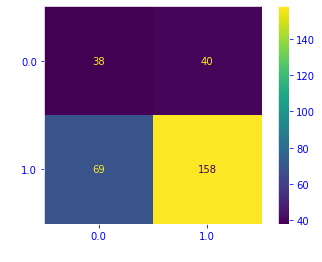

==========CLASSIFICATION REPORT==========
              precision    recall  f1-score   support

         0.0       0.36      0.49      0.41        78
         1.0       0.80      0.70      0.74       227

    accuracy                           0.64       305
   macro avg       0.58      0.59      0.58       305
weighted avg       0.68      0.64      0.66       305

==========AUC/ROC CURVE==========
AUC for our classifier is: 0.6443013667683272


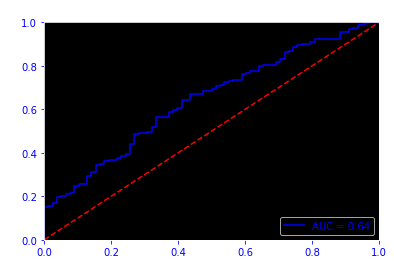

==========PR CURVE==========
Logistic: f1=0.744 auc=0.848


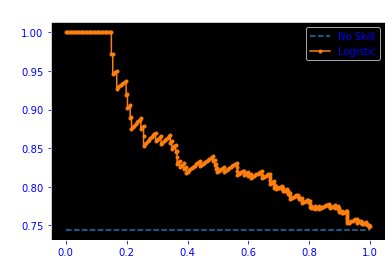

In [215]:
# Evaluate model 
evaluate(random_search,X_test_pca,y_test)

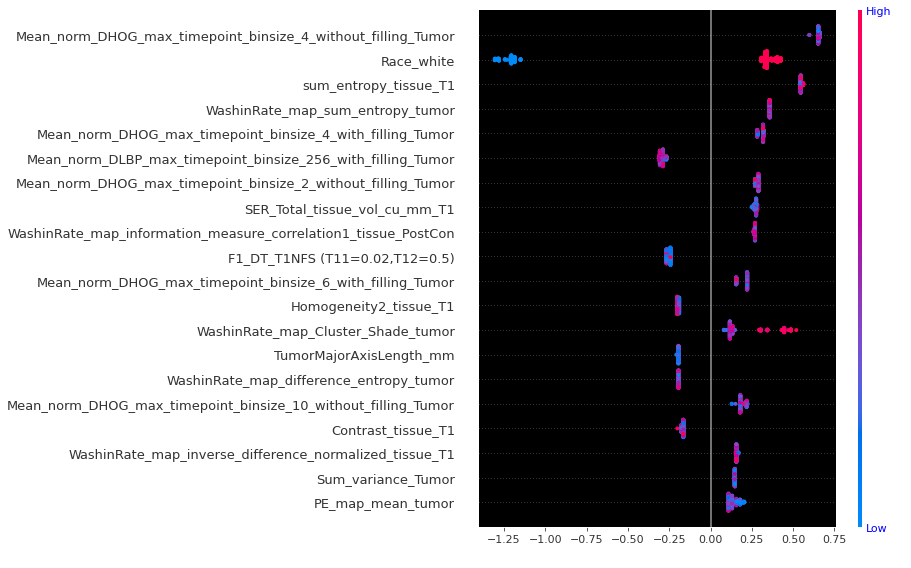

In [223]:
# Features importance 
shap_values = shap.TreeExplainer(random_search.best_estimator_).shap_values(X_test)
shap.summary_plot(shap_values, X_test)


# Images

In [221]:
# TAREGT 
data_all.ER.head()

Patient ID
Breast_MRI_001    0.0
Breast_MRI_002    0.0
Breast_MRI_003    1.0
Breast_MRI_004    1.0
Breast_MRI_005    1.0
Name: ER, dtype: float64

In [217]:
# Analyse images of two patients (ER=0/ER=1)
# First patient Breast_MRI_001 / Breast_MRI_003
patients=["Breast_MRI_001","Breast_MRI_003"]
## Paths of images
paths={patient:glob.glob("samples/"+patient+"/*/*/*.dcm") for patient in patients}
images={patient:[] for patient in patients}
for patient in tqdm(patients):
    for image_path in tqdm(paths[patient]):
        ds = dicom.dcmread(image_path)
        images[patient].append(ds.pixel_array)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/842 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

##### Visualize (ER=0, ER=1)

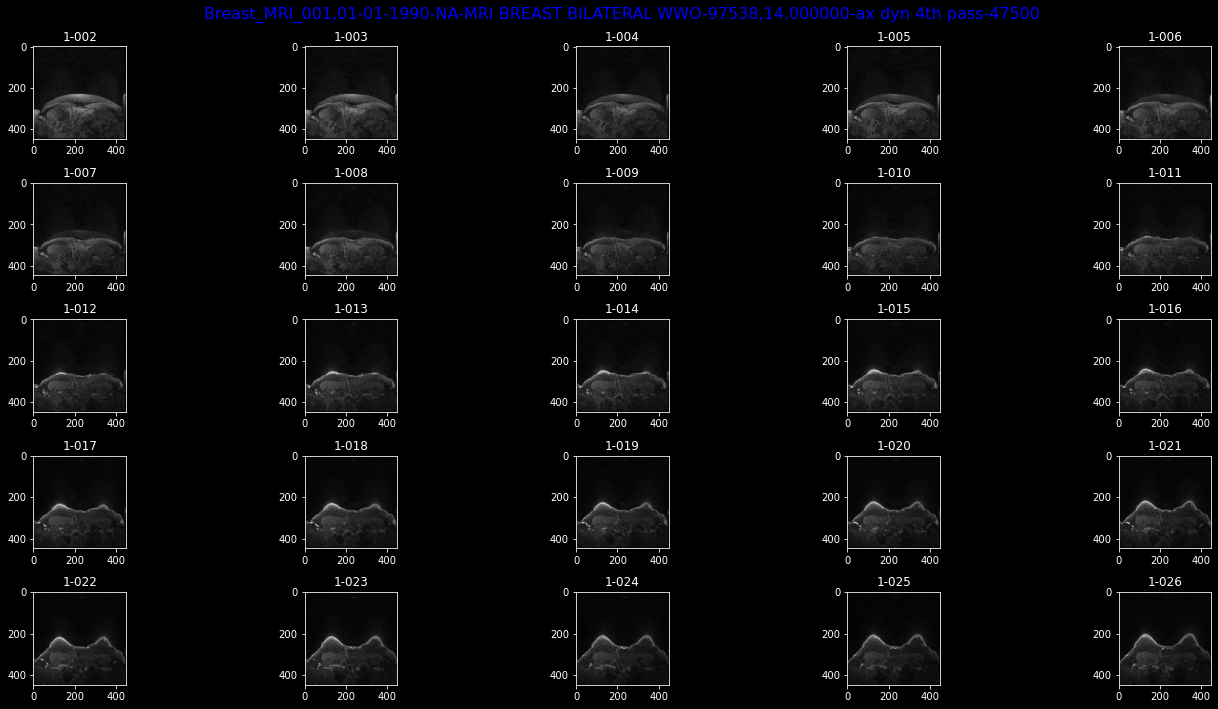

In [224]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
         "axes.titlecolor": "w",
         }
plt.rcParams.update(params)
w = 4
h = 2
fig = plt.figure(figsize=(20, 10),constrained_layout=True)
fig.patch.set_facecolor('black')
fig.suptitle(",".join(paths[patients[0]][i].split("/")[1].split("\\")[:-1]), fontsize=16)

columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img =  images[patients[0]][i]
    fig.add_subplot(rows, columns, i)
    plt.title(paths[patients[0]][i].split("/")[1].split("\\")[-1][:-4])
    plt.imshow(img,cmap="gray")
plt.tight_layout()
plt.show()
fig.savefig('images/sample_0.png')



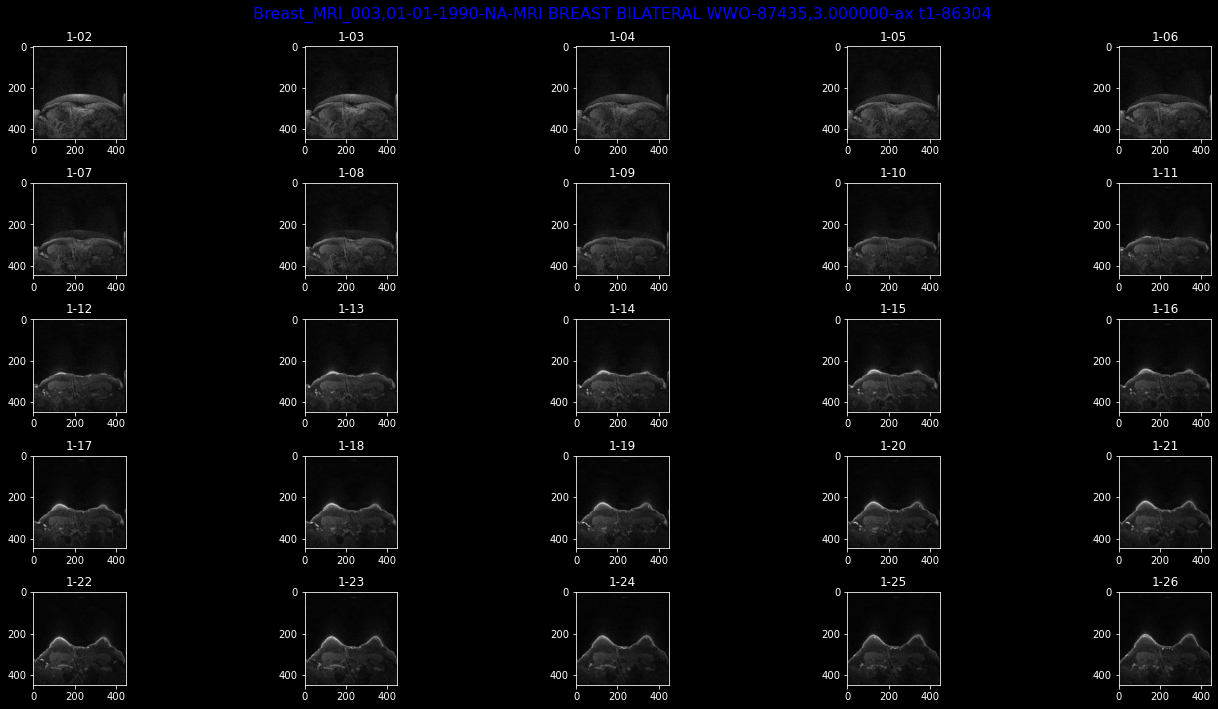

In [225]:
plt.rcParams.update(params)
w = 4
h = 2
fig = plt.figure(figsize=(20, 10),constrained_layout=True)
fig.patch.set_facecolor('black')
fig.suptitle(",".join(paths[patients[1]][i].split("/")[1].split("\\")[:-1]), fontsize=16)

columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img =  images[patients[0]][i]
    fig.add_subplot(rows, columns, i)
    plt.title(paths[patients[1]][i].split("/")[1].split("\\")[-1][:-4])
    plt.imshow(img,cmap="gray")
plt.tight_layout()
plt.show()
fig.savefig('images/sample_1.png')


## Extract our own features (computer vision on images)

In [227]:
patients = list(data_all.index)

#### Download images

In [96]:
import zipfile
# Find all te
images=  ImageDataset(patients)
# All files and directories ending with .txt and that don't begin with a dot:
finis  = list( glob.glob("./images/ZipFiles/*") ) 
for file in tqdm(finis):
    with zipfile.ZipFile(file, 'r') as zip_ref:
        print(file)
        zip_ref.extractall("./images/ax_t1/"+file.split('\\')[-1][:-4]+"/")

  0%|          | 0/1 [00:00<?, ?it/s]

./images/ZipFiles\Breast_MRI_613.zip


In [77]:
for patient in tqdm(patients): 
    tempdir = "c" 
    filename=os.path.join(tempdir, patient+'.txt')
    f= open(filename,"w+")
    f.write(str(int(data_all.loc[patient].ER)))
    f.close()
    

  0%|          | 0/922 [00:00<?, ?it/s]

## Read image filenames from the dataset folders
First of all, check the dataset files and show some statistics.
There are 6 folders in the dataset: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT,
which should be used as the labels to train our classification model.

In [49]:
# FIND IMAGES PATHS and Labels and establish a dataset
data_dir = './images/ax_t1/'
class_names = ['0','1']
num_class = len(class_names)
patients_0 = list(data_all[data_all.ER==0].index)
patients_1 = list(data_all[data_all.ER==1].index)
image_files = [[x for patient in patients_0 for x in glob.glob(data_dir+patient)
                ],[x  for patient in patients_1 for x in glob.glob(data_dir+patient)
               ]]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

print('Total image count:', num_total)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 922
Label names: ['0', '1']
Label counts: [236, 686]


In [233]:
# Load data 
loader = LoadImage()
loader.register(ITKReader())
data, meta = loader(image_file_list[0])

print(f"image data shape:{data.shape}")
print(f"meta data:{meta}")

image data shape:(256, 256, 42)
meta data:{'spacing': array([1.328125  , 1.328125  , 3.98999984]), 'original_affine': array([[-1.32723302e+00, -2.72220070e-10,  1.46208396e-01,
         1.75605262e+02],
       [ 2.72403020e-10, -1.32812500e+00,  1.94412091e-16,
         1.66125908e+02],
       [ 4.86674270e-02,  9.98192188e-12,  3.98732013e+00,
        -8.21583552e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), 'affine': array([[-1.32723302e+00, -2.72220070e-10,  1.46208396e-01,
         1.75605262e+02],
       [ 2.72403020e-10, -1.32812500e+00,  1.94412091e-16,
         1.66125908e+02],
       [ 4.86674270e-02,  9.98192188e-12,  3.98732013e+00,
        -8.21583552e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), 'spatial_shape': array([256, 256,  42]), 'original_channel_dim': 'no_channel', 'filename_or_obj': 'images\\ax_t1\\Breast_MRI_001'}


## Prepare training, validation and test data lists
Randomly select 10% of the dataset as validation and 10% as test( afterwards we can define test as Lunit's test)

In [57]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 731 Validation count = 97 Test count = 94


## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [235]:
loader = LoadImage()
loader.register(ITKReader())
transform = Compose([
    LoadImaged(keys="image"),
    EnsureChannelFirstd(keys="image"),
    Resized(keys="image", spatial_size=[64, 64,42]),
    EnsureTyped("image"),
    ToTensor()
])
train_transforms = Compose([
    LoadImaged(keys="image"),
    EnsureChannelFirstd(keys="image"),
    Resized(keys="image", spatial_size=[64, 64,42]),
    EnsureTyped("image"),
    ToTensor()
])

val_transforms = Compose([
    LoadImaged(keys="image"),
    EnsureChannelFirstd(keys="image"),
    Resized(keys="image", spatial_size=[64, 64,42]),
    ToTensor()
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=True, n_classes=num_class)


In [241]:
from monai.data import Dataset as monaiDataset, DataLoader as monaiDataLoader
from utils.MRIDataset import  MRIDataset

train_ds = MRIDataset(trainX, trainY, train_transforms )
train_loader = monaiDataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)

val_ds = MRIDataset(valX, valY, val_transforms)
val_loader = monaiDataLoader(val_ds, batch_size=8, num_workers=0)

test_ds = MRIDataset(testX, testY, val_transforms)
test_loader = monaiDataLoader(test_ds, batch_size=8, num_workers=0)

## Define network and optimizer
1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
3. Use DenseNet from MONAI, this DenseNet can support 3D classification tasks.
4. Use Adam optimizer.

In [112]:
import torch
device = torch.device("cpu")
model = DenseNet121(
    spatial_dims=3,
    in_channels=1,
    out_channels=num_class
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 4
val_interval = 1
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
            
            
### extract features :
feature_extract = True

### Model training
Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.
Will save the model weights to file if got best validation accuracy.

In [126]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0]['image'].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0]['image'].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'models/best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/91, train_loss: 0.5596
2/91, train_loss: 0.5279
3/91, train_loss: 0.6319
4/91, train_loss: 0.6918
5/91, train_loss: 0.6020
6/91, train_loss: 0.6411
7/91, train_loss: 0.5696
8/91, train_loss: 0.4917
9/91, train_loss: 0.6501
10/91, train_loss: 0.7663
11/91, train_loss: 0.5918
12/91, train_loss: 0.6141
13/91, train_loss: 0.4645
14/91, train_loss: 0.4659
15/91, train_loss: 0.4660
16/91, train_loss: 0.4637
17/91, train_loss: 0.4972
18/91, train_loss: 0.5545
19/91, train_loss: 0.7142
20/91, train_loss: 0.5474
21/91, train_loss: 0.5639
22/91, train_loss: 0.5808
23/91, train_loss: 0.6536
24/91, train_loss: 0.5194
25/91, train_loss: 0.5200
26/91, train_loss: 0.6579
27/91, train_loss: 0.5238
28/91, train_loss: 0.6678
29/91, train_loss: 0.6741
30/91, train_loss: 0.6819
31/91, train_loss: 0.6305
32/91, train_loss: 0.4629
33/91, train_loss: 0.6115
34/91, train_loss: 0.5691
35/91, train_loss: 0.6086
36/91, train_loss: 0.4610
37/91, train_loss: 0.6427
38/91, train_loss: 0.6516


24/91, train_loss: 0.4328
25/91, train_loss: 0.5743
26/91, train_loss: 0.6025
27/91, train_loss: 0.4312
28/91, train_loss: 0.4229
29/91, train_loss: 0.7015
30/91, train_loss: 0.8519
31/91, train_loss: 0.3124
32/91, train_loss: 0.3563
33/91, train_loss: 0.5401
34/91, train_loss: 0.5436
35/91, train_loss: 0.9625
36/91, train_loss: 0.7067
37/91, train_loss: 0.4014
38/91, train_loss: 0.4056
39/91, train_loss: 0.6071
40/91, train_loss: 0.7822
41/91, train_loss: 0.3192
42/91, train_loss: 0.9282
43/91, train_loss: 0.3820
44/91, train_loss: 0.5947
45/91, train_loss: 0.5231
46/91, train_loss: 0.5499
47/91, train_loss: 0.4497
48/91, train_loss: 0.6564
49/91, train_loss: 0.6510
50/91, train_loss: 0.6313
51/91, train_loss: 0.5734
52/91, train_loss: 0.3718
53/91, train_loss: 0.5450
54/91, train_loss: 0.6318
55/91, train_loss: 0.3842
56/91, train_loss: 0.6031
57/91, train_loss: 0.4364
58/91, train_loss: 0.4610
59/91, train_loss: 0.3271
60/91, train_loss: 0.5567
61/91, train_loss: 0.3867
62/91, train

###  Losses

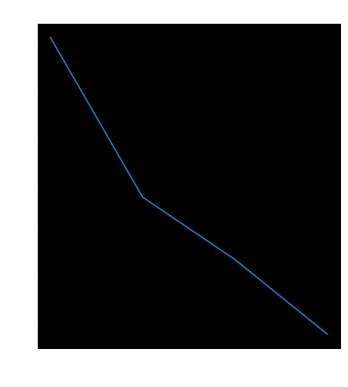

In [247]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

## Evaluate the model on test dataset
After training and validation, we already got the best model on validation test.
We need to evaluate the model on test dataset to check whether it's robust and not over-fitting.
We'll use these predictions to generate a classification report.

In [250]:
model.load_state_dict(torch.load('models/best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0]['image'].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [251]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        24
           1     0.7447    1.0000    0.8537        70

    accuracy                         0.7447        94
   macro avg     0.3723    0.5000    0.4268        94
weighted avg     0.5545    0.7447    0.6357        94



the model clearly overfit on the imbalanced classes 